In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from skimage.transform import resize
from tensorflow.keras import models, layers, optimizers
import tensorflow as tf
from sklearn.utils import shuffle

7


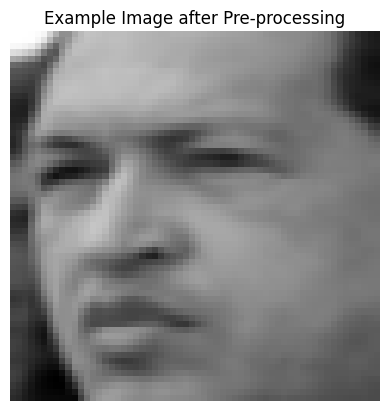

In [ ]:
# Load and preprocess the dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print(n_classes)

# Resize images
new_size = (60, 60)
resized_images = np.zeros((len(X), new_size[0], new_size[1]))
for i, image in enumerate(X):
    resized_images[i] = resize(image.reshape((h, w)), new_size, mode='reflect', anti_aliasing=True)

# Normalize the pixel values to be between 0 and 1
resized_images_normalized = resized_images / np.max(resized_images)

# Display the first image after pre-processing
plt.imshow(resized_images_normalized[0], cmap='gray')
plt.title("Example Image after Pre-processing")
plt.axis('off')
plt.show()

Number of Unique Classes: 7


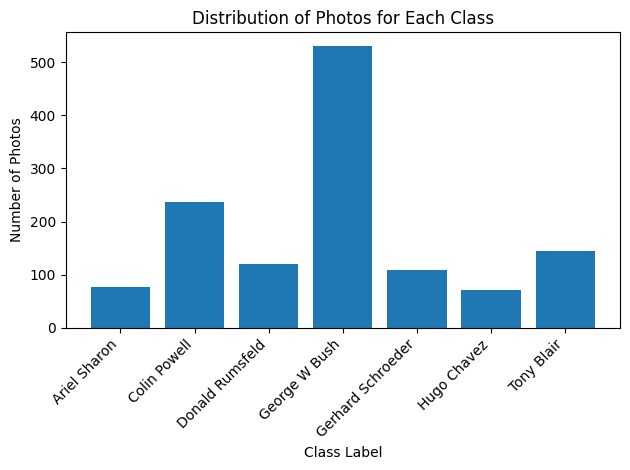

In [ ]:
# Show the number of unique classes
unique_classes = np.unique(y)
num_unique_classes = len(unique_classes)
print("Number of Unique Classes:", num_unique_classes)

# Show the distribution of photos associated with each class
class_distribution = {class_label: np.sum(y == class_label) for class_label in unique_classes}

# Display names of class labels on the chart
class_labels_with_names = [target_names[class_label] for class_label in class_distribution.keys()]

plt.bar(class_labels_with_names, class_distribution.values())
plt.xlabel('Class Label')
plt.ylabel('Number of Photos')
plt.title('Distribution of Photos for Each Class')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Identify the class with the maximum representation in the original dataset
max_class_count = max(class_distribution.values())

# Define the maximum proportion of the original class count for augmented data
max_proportion = 1.5

#ImageDataGenerator from keras used for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation in the range of [-20, 20] degrees
    width_shift_range=0.1,  # Random horizontal shift by 10%
    height_shift_range=0.1,  # Random vertical shift by 10%
    shear_range=0.2,  # Shear intensity (shear angle in radians)
    zoom_range=0.2,  # Random zoom in the range of [0.8, 1.2]
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill mode for points outside the input boundaries
)

In [ ]:

def augment_data(X, y, max_count):
    augmented_data = []
    augmented_labels = []
    augmented_counts = {class_label: 0 for class_label in unique_classes}

    for i in range(len(X)):
        image = X[i].reshape((new_size[0], new_size[1], 1))
        label = y[i]

        # Reshape image for the flow method
        image = np.expand_dims(image, axis=0)

        # Generate augmented images
        for x_aug, y_aug in datagen.flow(image, [label], batch_size=1, shuffle=False):
            augmented_data.append(x_aug[0, :, :, 0])
            augmented_labels.append(y_aug[0])
            augmented_counts[label] += 1

            # Break to generate only one augmented image per original image
            if augmented_counts[label] >= max_count:
                break

    return np.array(augmented_data), np.array(augmented_labels)

In [ ]:
# Augment the entire dataset
X_augmented, y_augmented = augment_data(resized_images_normalized, y, max_class_count)

# Split the augmented dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_augmented, y_augmented, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.8, random_state=42)

# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Display the distribution of photos after data augmentation for the training set
class_distribution_augmented_train = {class_label: np.sum(y_train == class_label) for class_label in unique_classes}
class_distribution_augmented_val = {class_label: np.sum(y_val == class_label) for class_label in unique_classes}
class_distribution_augmented_test = {class_label: np.sum(y_test == class_label) for class_label in unique_classes}

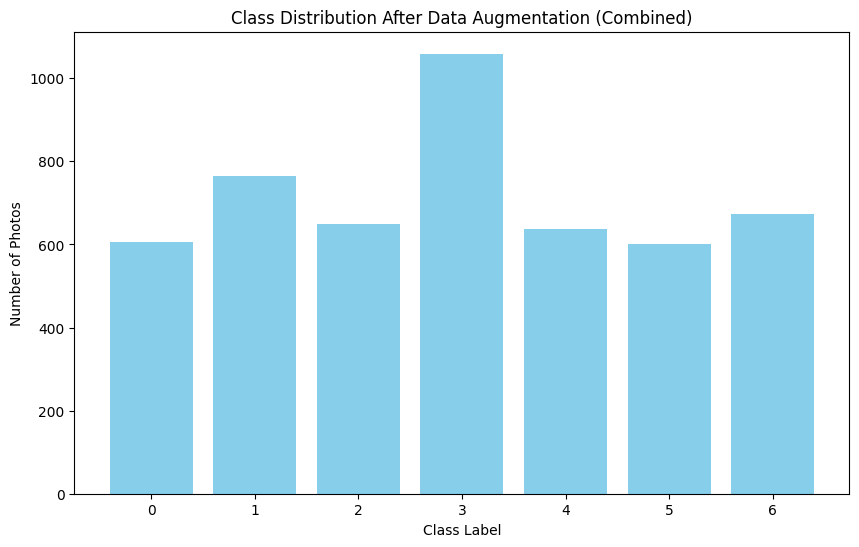

In [ ]:
# Combine all data
X_combined = np.concatenate((X_train, X_val, X_test), axis=0)
y_combined = np.concatenate((y_train, y_val, y_test), axis=0)

# Shuffle the combined data
X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

# Display the distribution of photos after data augmentation for the combined set
class_distribution_combined = {class_label: np.sum(y_combined == class_label) for class_label in unique_classes}

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_distribution_combined.keys(), class_distribution_combined.values(), color='skyblue')
plt.title('Class Distribution After Data Augmentation (Combined)')
plt.xlabel('Class Label')
plt.ylabel('Number of Photos')
plt.show()

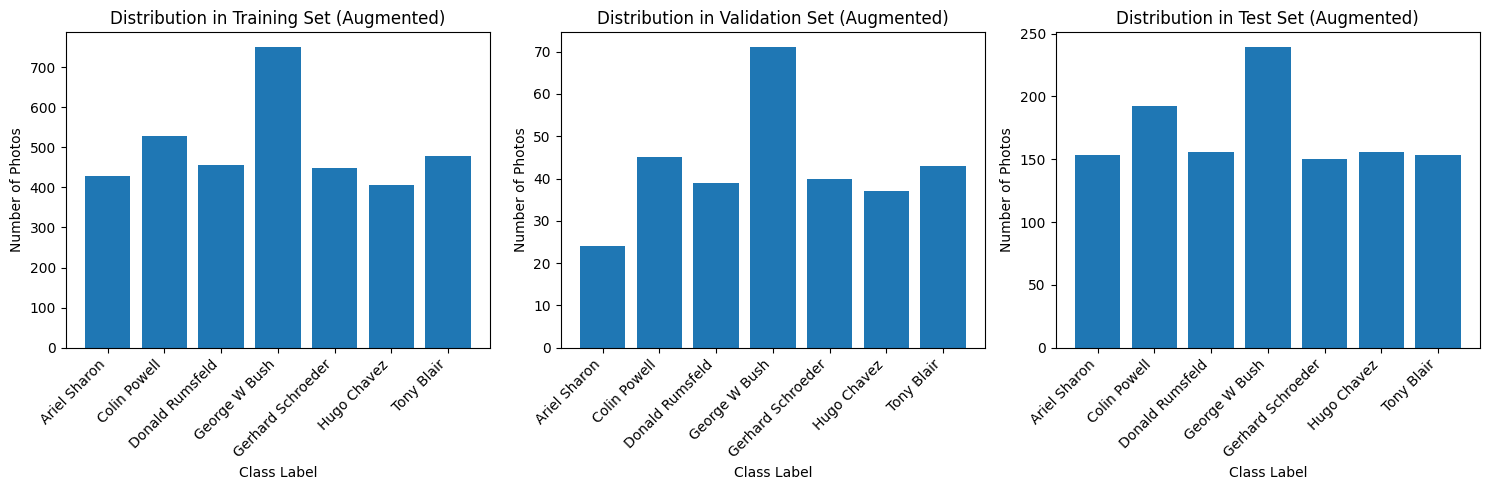

In [ ]:
# Plot the distribution of photos for each class in the training set
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.bar(class_labels_with_names, class_distribution_augmented_train.values())
plt.xlabel('Class Label')
plt.ylabel('Number of Photos')
plt.title('Distribution in Training Set (Augmented)')
plt.xticks(rotation=45, ha='right')

# Plot the distribution of photos for each class in the validation set
plt.subplot(1, 3, 2)
plt.bar(class_labels_with_names, class_distribution_augmented_val.values())
plt.xlabel('Class Label')
plt.ylabel('Number of Photos')
plt.title('Distribution in Validation Set (Augmented)')
plt.xticks(rotation=45, ha='right')

# Plot the distribution of photos for each class in the test set
plt.subplot(1, 3, 3)
plt.bar(class_labels_with_names, class_distribution_augmented_test.values())
plt.xlabel('Class Label')
plt.ylabel('Number of Photos')
plt.title('Distribution in Test Set (Augmented)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
def generate_triplets(images, labels, num_triplets, input_shape=(60, 60, 1), val_fraction=0.2, test_fraction=0.1):
    # Initialize lists to hold the triplets for training, validation, and testing
    triplets = []
    val_triplets = []
    test_triplets = []

    # Get the unique labels from the dataset
    unique_labels = np.unique(labels)

    # Calculate the number of triplets for validation and testing based on the fractions
    num_val = int(num_triplets * val_fraction)
    num_test = int(num_triplets * test_fraction)

    # The remaining triplets will be used for training
    num_train = num_triplets - num_val - num_test

    # Split the indices of the images into training, validation, and testing sets
    train_indices, test_indices = train_test_split(np.arange(len(labels)), test_size=val_fraction + test_fraction, random_state=42)
    test_indices, val_indices = train_test_split(test_indices, test_size=val_fraction / (val_fraction + test_fraction), random_state=42)

    # Print the number of indices for each set
    print("Number of training indices:", len(train_indices))
    print("Number of validation indices:", len(val_indices))
    print("Number of testing indices:", len(test_indices))

    # Inner function to create triplets given a target list and a set of indices
    def create_triplets(target_list, num_triplets, indices, current_labels):
        for _ in range(num_triplets):
            # Randomly choose an index to be the anchor
            anchor_index = np.random.choice(indices)
            anchor_label = current_labels[anchor_index]

            # Choose a positive example with the same label as the anchor
            positive_index = np.random.choice(np.where(labels == anchor_label)[0])

            # Choose a negative example with a different label from the anchor
            negative_label = np.random.choice(unique_labels[unique_labels != anchor_label])
            negative_index = np.random.choice(np.where(labels == negative_label)[0])

            # Resize the images to the input shape and add them to the target list as a triplet
            anchor_image = resize(images[anchor_index], input_shape, mode='reflect', anti_aliasing=True)
            positive_image = resize(images[positive_index], input_shape, mode='reflect', anti_aliasing=True)
            negative_image = resize(images[negative_index], input_shape, mode='reflect', anti_aliasing=True)

            # Add the triplet (anchor, positive, negative) to the target list
            target_list.append([anchor_image, positive_image, negative_image])

    # Create the triplets for each set using the respective indices
    create_triplets(triplets, num_train, train_indices, labels)
    create_triplets(val_triplets, num_val, val_indices, labels)
    create_triplets(test_triplets, num_test, test_indices, labels)

    # Print the length of each triplet list to verify the numbers
    print("Length of test_triplets:", len(test_triplets))
    print("Length of val_triplets:", len(val_triplets))
    print("Length of triplets:", len(triplets))

    # Prepare the test triplet images in the format suitable for model input
    test_input = [np.stack([triplet[0] for triplet in test_triplets], axis=0),
                  np.stack([triplet[1] for triplet in test_triplets], axis=0),
                  np.stack([triplet[2] for triplet in test_triplets], axis=0)]

    # Return the triplets for training, validation, and testing, along with the test input
    return np.array(triplets), np.array(val_triplets), np.array(test_triplets), test_input


In [ ]:
# Create training, validation, and testing triplets
#X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)
#train_triplets, val_triplets, test_triplets, test_input  = generate_triplets(shuffled_images, shuffled_labels, num_triplets=7*800, input_shape=(60, 60, 1), val_fraction=0.2, test_fraction=0.1)
train_triplets, val_triplets, test_triplets, test_input = generate_triplets(X_combined, y_combined, num_triplets=7*1600, input_shape=(60, 60, 1), val_fraction=0.3, test_fraction=0.2)

#print(len(test_input))


Number of training indices: 2495
Number of validation indices: 1498
Number of testing indices: 998
Length of test_triplets: 2240
Length of val_triplets: 3360
Length of triplets: 5600


In [ ]:
# Advanced Facenet architecture, with additional convolutional and pooling layers

"""
def create_advanced_facenet_model(input_shape=(60, 60, 1), embedding_size=128):
    input_anchor = layers.Input(shape=input_shape)
    input_positive = layers.Input(shape=input_shape)
    input_negative = layers.Input(shape=input_shape)

    # Shared layers
    shared_conv_1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
    shared_maxpool_1 = layers.MaxPooling2D((2, 2), padding='same')

    shared_conv_2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')
    shared_maxpool_2 = layers.MaxPooling2D((2, 2), padding='same')

    shared_conv_3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')
    shared_maxpool_3 = layers.MaxPooling2D((2, 2), padding='same')

    shared_flatten = layers.Flatten()
    shared_dense = layers.Dense(embedding_size, activation='linear')

    # Process each input
    processed_anchor = shared_dense(shared_flatten(shared_maxpool_3(shared_conv_3(shared_maxpool_2(shared_conv_2(shared_maxpool_1(shared_conv_1(input_anchor))))))))
    processed_positive = shared_dense(shared_flatten(shared_maxpool_3(shared_conv_3(shared_maxpool_2(shared_conv_2(shared_maxpool_1(shared_conv_1(input_positive))))))))
    processed_negative = shared_dense(shared_flatten(shared_maxpool_3(shared_conv_3(shared_maxpool_2(shared_conv_2(shared_maxpool_1(shared_conv_1(input_negative))))))))

    # Concatenate processed inputs
    concatenated = layers.concatenate([processed_anchor, processed_positive, processed_negative], axis=-1)

    model = models.Model(inputs=[input_anchor, input_positive, input_negative], outputs=concatenated)

    return model
    """

"\ndef create_advanced_facenet_model(input_shape=(60, 60, 1), embedding_size=128):\n    input_anchor = layers.Input(shape=input_shape)\n    input_positive = layers.Input(shape=input_shape)\n    input_negative = layers.Input(shape=input_shape)\n\n    # Shared layers\n    shared_conv_1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')\n    shared_maxpool_1 = layers.MaxPooling2D((2, 2), padding='same')\n\n    shared_conv_2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')\n    shared_maxpool_2 = layers.MaxPooling2D((2, 2), padding='same')\n\n    shared_conv_3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')\n    shared_maxpool_3 = layers.MaxPooling2D((2, 2), padding='same')\n\n    shared_flatten = layers.Flatten()\n    shared_dense = layers.Dense(embedding_size, activation='linear')\n\n    # Process each input\n    processed_anchor = shared_dense(shared_flatten(shared_maxpool_3(shared_conv_3(shared_maxpool_2(shared_conv_2(shared_maxpool_1(shared_c

In [ ]:
# Defining the FaceNet architecture

def create_facenet_model(input_shape=(60, 60, 1), embedding_size=128):
    input_anchor = layers.Input(shape=input_shape)
    input_positive = layers.Input(shape=input_shape)
    input_negative = layers.Input(shape=input_shape)

    # Shared layers
    shared_conv = layers.Conv2D(64, (3, 3), activation='relu')
    shared_maxpool = layers.MaxPooling2D((2, 2))
    shared_flatten = layers.Flatten()
    shared_dense = layers.Dense(embedding_size, activation='linear')

    # Process each input
    processed_anchor = shared_dense(shared_flatten(shared_maxpool(shared_conv(input_anchor))))
    processed_positive = shared_dense(shared_flatten(shared_maxpool(shared_conv(input_positive))))
    processed_negative = shared_dense(shared_flatten(shared_maxpool(shared_conv(input_negative))))

    # Concatenate processed inputs
    concatenated = layers.concatenate([processed_anchor, processed_positive, processed_negative], axis=-1)

    model = models.Model(inputs=[input_anchor, input_positive, input_negative], outputs=concatenated)

    return model


In [ ]:
# Create the FaceNet model
facenet_model = create_facenet_model(input_shape=(60, 60, 1))
#facenet_model = create_advanced_facenet_model(input_shape=(60, 60, 1))


In [ ]:
# Triplet Loss Function
def triplet_loss(margin=0.2):

  # y_true represents the true labels, y_pred represents the predicted values
  # Note loss is calculated solely on the predicted values, meaning that the presence of
  # predicted labels are here only due to the requirements of the .fit
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, :128], y_pred[:, 128:256], y_pred[:, 256:]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        basic_loss = pos_dist - neg_dist + margin
        # ensures that the loss is non negative
        return tf.reduce_mean(tf.maximum(basic_loss, 0.0))
    return loss

In [ ]:
# Compile the FaceNet model
facenet_model.compile(optimizer='adam', loss=triplet_loss(margin=1.0))
facenet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60, 60, 1)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 60, 60, 1)]          0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 60, 60, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 58, 58, 64)           640       ['input_1[0][0]',             
                                                                     'input_2[0][0]',         

In [ ]:
"""
# Define the number of folds for KFold cross-validation
#5-fold cross-validation
n_splits = 5

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Placeholder for cross-validation scores
cv_scores = []

# Loop through the folds in KFold
for fold, (train_index, val_index) in enumerate(kf.split(train_triplets)):
    print(f"Training on fold {fold+1}/{n_splits}...")
    # Split the triplets into training and validation sets for this fold
    train_triplets_fold = train_triplets[train_index]
    val_triplets_fold = train_triplets[val_index]

    # Perform any necessary preprocessing like data augmentation within this fold

    # Prepare the data for the model
    train_input_fold = [np.stack([triplet[i] for triplet in train_triplets_fold], axis=0) for i in range(3)]
    val_input_fold = [np.stack([triplet[i] for triplet in val_triplets_fold], axis=0) for i in range(3)]

    # Prepare dummy labels for training and validation data
    train_labels_fold = np.zeros((len(train_triplets_fold),))  # Dummy labels
    val_labels_fold = np.zeros((len(val_triplets_fold),))  # Dummy labels

    # Define and compile the model architecture
    facenet_model = create_facenet_model(input_shape=(60, 60, 1))
    facenet_model.compile(optimizer='adam', loss=triplet_loss(margin=1.0))

    # Train the model on this fold's training data
    facenet_model.fit(train_input_fold, train_labels_fold, epochs=5, batch_size=32)

    # Evaluate the model on this fold's validation data
    val_loss = facenet_model.evaluate(val_input_fold, val_labels_fold)
    print(f'Fold {fold+1} Validation Loss: {val_loss}')

    # Save the validation loss for this fold
    cv_scores.append(val_loss)

# Calculate and print the average cross-validation score
average_cv_score = np.mean(cv_scores)
print(f'Average Cross-Validation Score: {average_cv_score}')
"""

'\n# Define the number of folds for KFold cross-validation\n#5-fold cross-validation\nn_splits = 5\n\n# Initialize KFold\nkf = KFold(n_splits=n_splits, shuffle=True, random_state=42)\n\n# Placeholder for cross-validation scores\ncv_scores = []\n\n# Loop through the folds in KFold\nfor fold, (train_index, val_index) in enumerate(kf.split(train_triplets)):\n    print(f"Training on fold {fold+1}/{n_splits}...")\n    # Split the triplets into training and validation sets for this fold\n    train_triplets_fold = train_triplets[train_index]\n    val_triplets_fold = train_triplets[val_index]\n\n    # Perform any necessary preprocessing like data augmentation within this fold\n\n    # Prepare the data for the model\n    train_input_fold = [np.stack([triplet[i] for triplet in train_triplets_fold], axis=0) for i in range(3)]\n    val_input_fold = [np.stack([triplet[i] for triplet in val_triplets_fold], axis=0) for i in range(3)]\n\n    # Prepare dummy labels for training and validation data\n   

In [ ]:
# Train the model
# Prepare dummy labels for training data
# This is because the triplet loss function does not use these labels, but they are required by the fit method
train_labels = np.zeros((len(train_triplets),))  # Dummy labels


# Training the model
# Concatenate images along the last axis (channel axis)
train_input = [np.stack([triplet[0] for triplet in train_triplets], axis=0),
               np.stack([triplet[1] for triplet in train_triplets], axis=0),
               np.stack([triplet[2] for triplet in train_triplets], axis=0)]

history = facenet_model.fit(train_input, train_labels, epochs=25, batch_size=32)


Epoch 1/25
175/175 [==============================] - 77s 429ms/step - loss: 0.4861
Epoch 2/25
175/175 [==============================] - 70s 400ms/step - loss: 0.2689
Epoch 3/25
175/175 [==============================] - 68s 388ms/step - loss: 0.1739
Epoch 4/25
175/175 [==============================] - 67s 380ms/step - loss: 0.1255
Epoch 5/25
175/175 [==============================] - 67s 384ms/step - loss: 0.0873
Epoch 6/25
175/175 [==============================] - 65s 374ms/step - loss: 0.0725
Epoch 7/25
175/175 [==============================] - 70s 400ms/step - loss: 0.0530
Epoch 8/25
175/175 [==============================] - 66s 378ms/step - loss: 0.0463
Epoch 9/25
175/175 [==============================] - 67s 380ms/step - loss: 0.0572
Epoch 10/25
175/175 [==============================] - 67s 382ms/step - loss: 0.0370
Epoch 11/25
175/175 [==============================] - 66s 375ms/step - loss: 0.0326
Epoch 12/25
175/175 [==============================] - 67s 381ms/step - lo

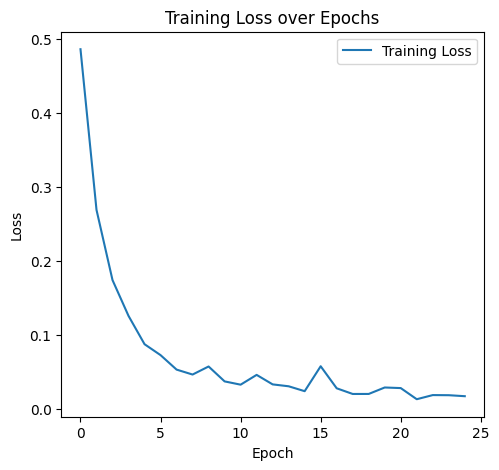

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()


In [ ]:
# Evaluate the model
# Prepare the validation data in the same format as the training data
val_input = [np.stack([triplet[0] for triplet in val_triplets], axis=0),
             np.stack([triplet[1] for triplet in val_triplets], axis=0),
             np.stack([triplet[2] for triplet in val_triplets], axis=0)]

# Prepare dummy labels for validation data
val_labels = np.zeros((len(val_triplets),))  # Dummy labels since they aren't used in loss calculation

# Evaluate the model on the validation data
val_loss = facenet_model.evaluate(val_input, val_labels)
print(f'Validation Loss: {val_loss}')

105/105 [==============================] - 10s 97ms/step - loss: 1.1058
Validation Loss: 1.1057876348495483


In [ ]:

#print(len(X_train))
#print(len(X_val))
#print(len(test_input))
# Generate embeddings for training, validation, and testing data

train_embeddings = facenet_model.predict([X_train, X_train, X_train])
val_embeddings = facenet_model.predict([X_val, X_val, X_val])
test_embeddings = facenet_model.predict(test_input)


"""
train_embeddings_augmented = facenet_model.predict([X_train_augmented, X_train_augmented, X_train_augmented])
val_embeddings_augmented = facenet_model.predict([X_val_augmented, X_val_augmented, X_val_augmented])
test_embeddings_augmented = facenet_model.predict(X_augmented)
"""


70/70 [==============================] - 6s 83ms/step


'\ntrain_embeddings_augmented = facenet_model.predict([X_train_augmented, X_train_augmented, X_train_augmented])\nval_embeddings_augmented = facenet_model.predict([X_val_augmented, X_val_augmented, X_val_augmented])\ntest_embeddings_augmented = facenet_model.predict(X_augmented)\n'

In [ ]:

# Train SVM on top of the embeddings
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

classifier = SVC(kernel='linear', probability=True)
classifier.fit(train_embeddings, y_train)


param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=3)
grid_search.fit(train_embeddings, y_train)
print("Best parameters:", grid_search.best_params_)


# Make predictions on validation and testing data
val_predictions = classifier.predict(val_embeddings)
test_predictions = classifier.predict(test_embeddings)

# Evaluate the classifier's performance on validation data
val_accuracy = accuracy_score(y_val, val_predictions)
val_precision = precision_score(y_val, val_predictions, average='weighted')
val_recall = recall_score(y_val, val_predictions, average='weighted')
val_f1 = f1_score(y_val, val_predictions, average='weighted')

print("Validation Metrics:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")

print("Length of y_test:", len(y_test))
print("Length of test_predictions:", len(test_predictions))

# Slice y_test to match the length of test_predictions
# The reason for the need of slicing here is because the arrays
# y_test_sliced and test_predictions must match in lenght, so this is just a simple workaround to that
min_length = min(len(y_test), len(test_predictions))
y_test_sliced = y_test[:min_length]
test_predictions = test_predictions[:min_length]


# Evaluate the classifier's performance on testing data with sliced y_test
test_accuracy = accuracy_score(y_test_sliced, test_predictions)
test_precision = precision_score(y_test_sliced, test_predictions, average='weighted')
test_recall = recall_score(y_test_sliced, test_predictions, average='weighted')
test_f1 = f1_score(y_test_sliced, test_predictions, average='weighted')

print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

class_report = classification_report(y_test_sliced, test_predictions, target_names=target_names)
print("Class-wise Metrics:")
print(class_report)

Best parameters: {'C': 1, 'kernel': 'rbf'}
Validation Metrics:
Accuracy: 0.8796
Precision: 0.8838
Recall: 0.8796
F1 Score: 0.8800
Length of y_test: 1199
Length of test_predictions: 2240

Testing Metrics:
Accuracy: 0.1443
Precision: 0.1384
Recall: 0.1443
F1 Score: 0.1388
Class-wise Metrics:
                   precision    recall  f1-score   support

     Ariel Sharon       0.14      0.12      0.13       153
     Colin Powell       0.15      0.12      0.14       192
  Donald Rumsfeld       0.10      0.06      0.08       156
    George W Bush       0.22      0.31      0.26       239
Gerhard Schroeder       0.08      0.09      0.09       150
      Hugo Chavez       0.14      0.10      0.12       156
       Tony Blair       0.09      0.12      0.10       153

         accuracy                           0.14      1199
        macro avg       0.13      0.13      0.13      1199
     weighted avg       0.14      0.14      0.14      1199



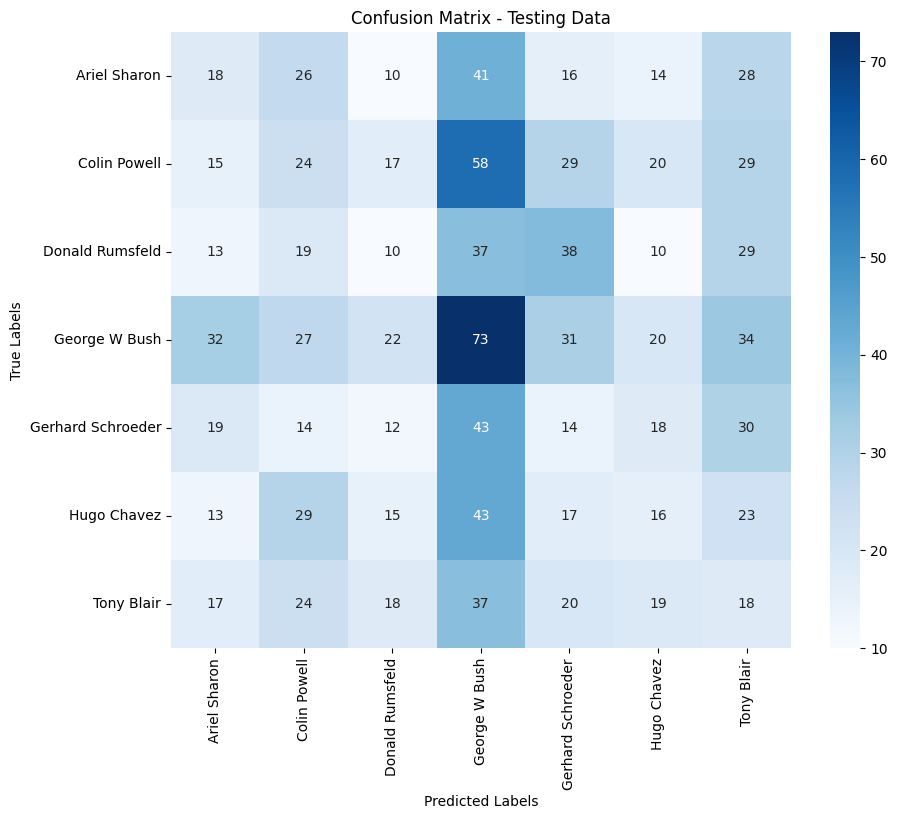

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix for testing data
conf_matrix = confusion_matrix(y_test_sliced, test_predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Testing Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

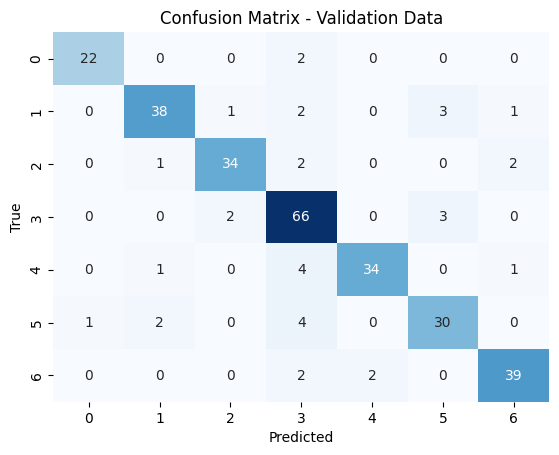

Actual: 4, Predicted: 6


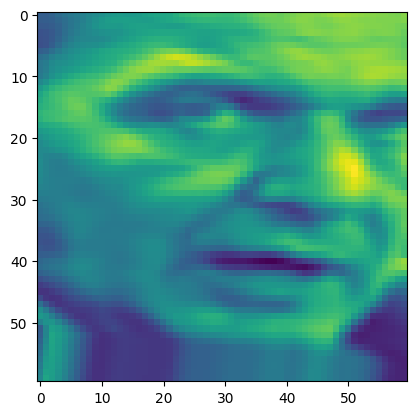

Actual: 3, Predicted: 5


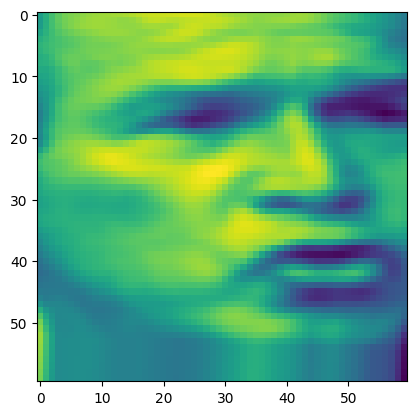

Actual: 4, Predicted: 3


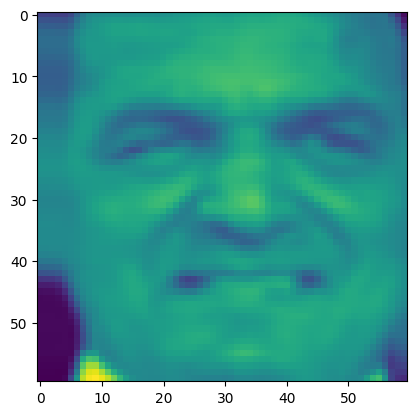

Actual: 1, Predicted: 6


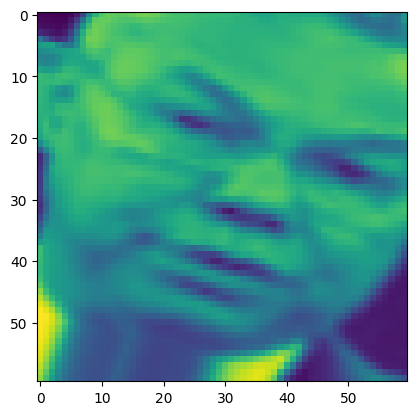

Actual: 6, Predicted: 4


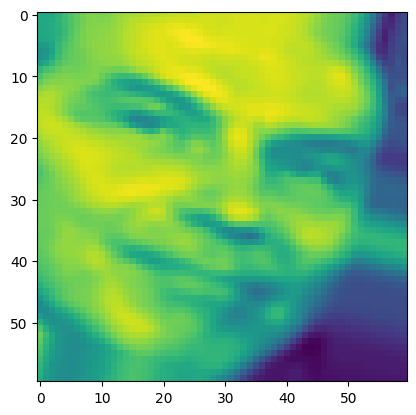

Actual: 5, Predicted: 3


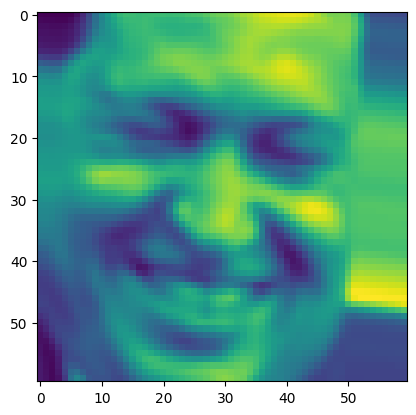

Actual: 2, Predicted: 6


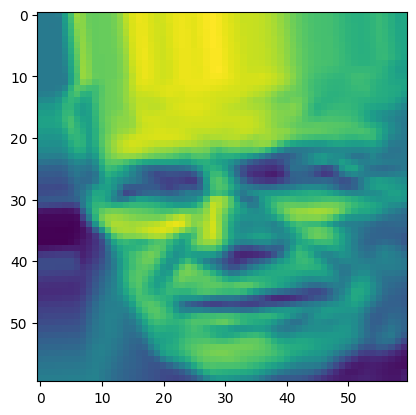

Actual: 5, Predicted: 0


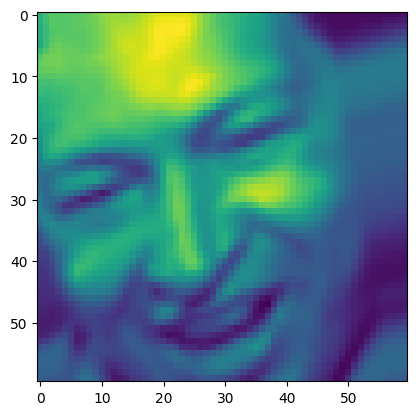

Actual: 1, Predicted: 2


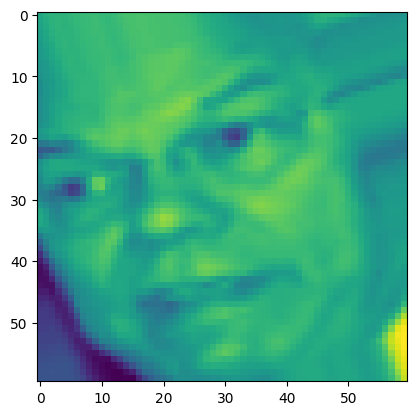

Actual: 5, Predicted: 3


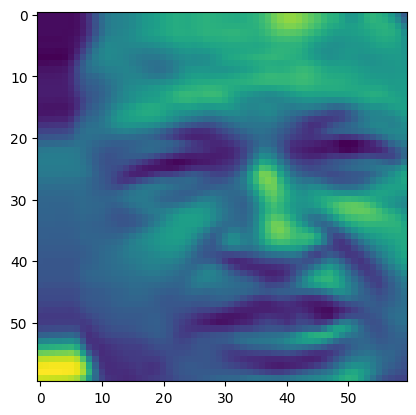

Actual: 0, Predicted: 6


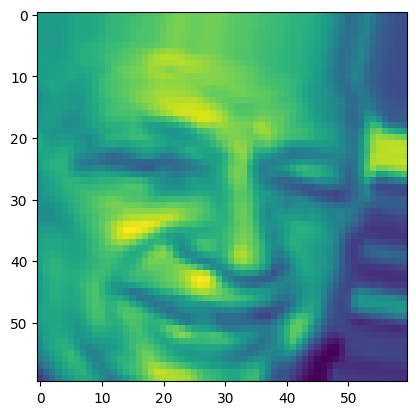

Actual: 2, Predicted: 4


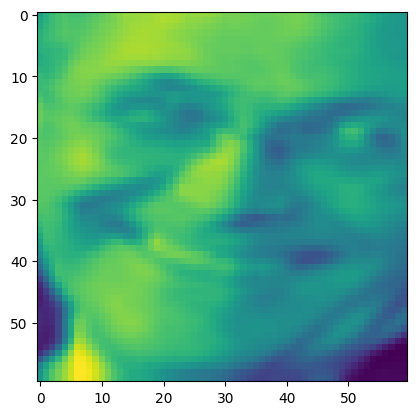

Actual: 6, Predicted: 1


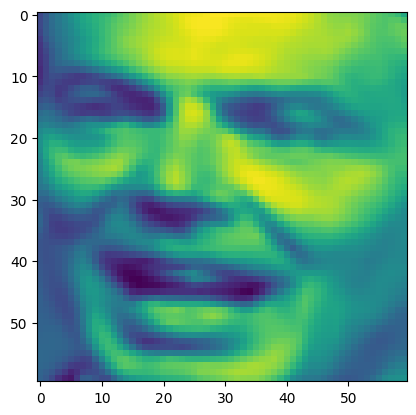

Actual: 1, Predicted: 0


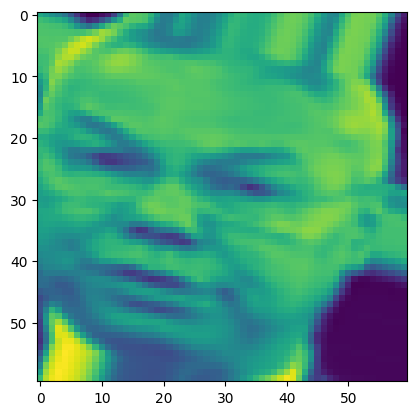

Actual: 6, Predicted: 3


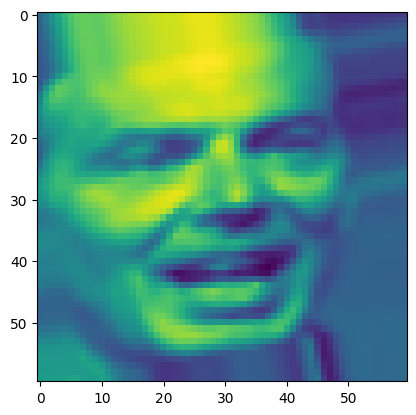

Actual: 1, Predicted: 3


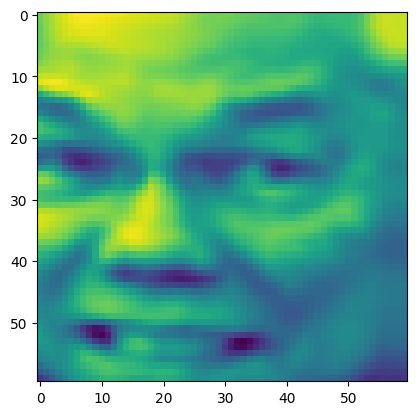

Actual: 4, Predicted: 6


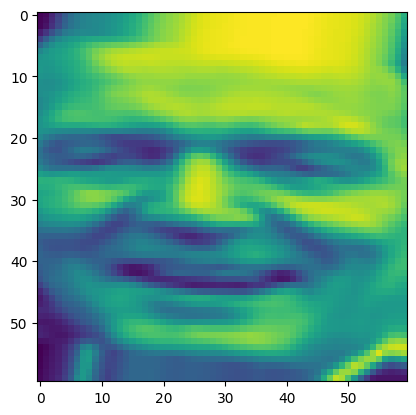

Actual: 2, Predicted: 1


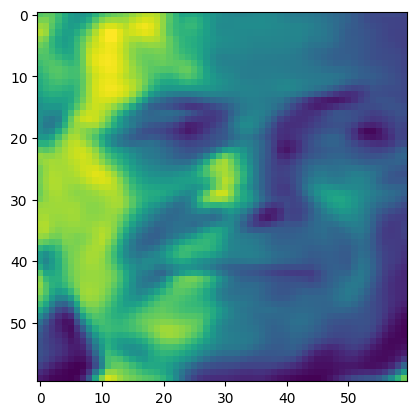

Actual: 6, Predicted: 3


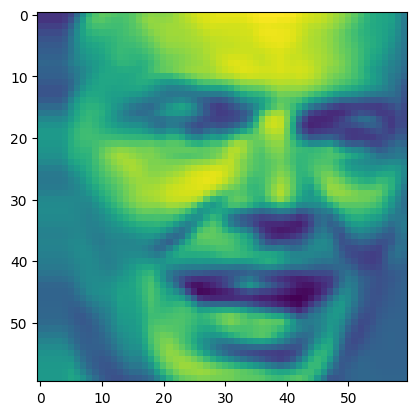

Actual: 1, Predicted: 4


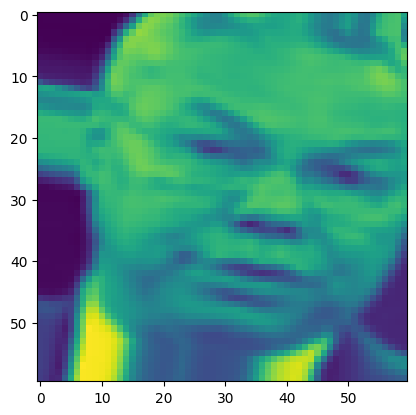

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Confusion matrix for validation data
val_cm = confusion_matrix(y_val, val_predictions)

# Visualize the confusion matrix
sns.heatmap(val_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Validation Data")
plt.show()

# Find misclassified indices for validation data
val_misclassified_indices = [i for i in range(len(y_val)) if y_val[i] != val_predictions[i]]

# Find misclassified indices for testing data
test_misclassified_indices = [i for i in range(len(y_test_sliced)) if y_test_sliced[i] != test_predictions[i]]

# Visualize misclassifications for validation data
random_val_misclassified_indices = random.sample(val_misclassified_indices, min(10, len(val_misclassified_indices)))
for idx in random_val_misclassified_indices:
    print(f"Actual: {y_val[idx]}, Predicted: {val_predictions[idx]}")
    plt.imshow(X_val[idx])  # Assuming X_val contains your validation images
    plt.show()

# Visualize misclassifications for testing data
random_test_misclassified_indices = random.sample(test_misclassified_indices, min(10, len(test_misclassified_indices)))
for idx in random_test_misclassified_indices:
    print(f"Actual: {y_test_sliced[idx]}, Predicted: {test_predictions[idx]}")
    plt.imshow(X_test[idx])  # Assuming X_test contains your testing images
    plt.show()

In [ ]:
#print("Unique classes in y_test:", np.unique(y_test))
#print("Unique classes in test_predictions:", np.unique(test_predictions))

In [ ]:
conf_matrix = confusion_matrix(y_test_sliced, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[18 26 10 41 16 14 28]
 [15 24 17 58 29 20 29]
 [13 19 10 37 38 10 29]
 [32 27 22 73 31 20 34]
 [19 14 12 43 14 18 30]
 [13 29 15 43 17 16 23]
 [17 24 18 37 20 19 18]]


In [ ]:
target_names = lfw_people.target_names
class_report = classification_report(y_test_sliced, test_predictions, target_names=target_names)
print("Class-wise Metrics:")
print(class_report)

Class-wise Metrics:
                   precision    recall  f1-score   support

     Ariel Sharon       0.14      0.12      0.13       153
     Colin Powell       0.15      0.12      0.14       192
  Donald Rumsfeld       0.10      0.06      0.08       156
    George W Bush       0.22      0.31      0.26       239
Gerhard Schroeder       0.08      0.09      0.09       150
      Hugo Chavez       0.14      0.10      0.12       156
       Tony Blair       0.09      0.12      0.10       153

         accuracy                           0.14      1199
        macro avg       0.13      0.13      0.13      1199
     weighted avg       0.14      0.14      0.14      1199

